In [1]:
import os
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt


import xgboost as xgb
from sklearn.metrics import mean_squared_error

import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def add_features(df):
    df['hour'] = df['ds'].apply(lambda x: int(x.split(':')[0]))
    df['min'] = df['ds'].apply(lambda x: int(x.split(':')[1]))
    df['series'] = np.arange(1, len(df) + 1)
    # q_diff는 필요하지 않아보임. 현재까지의 누적량이 영향을 미침.
    # df['q_diff'] = df['q_val'] - df['q_val'].shift(1)
    df.drop(['ds'], axis=1, inplace=True)
    return df

In [3]:
df_list = []
file_list = os.listdir('./data')
for file in file_list:
    df = pd.read_csv(f'./data/{file}', encoding='euc-kr')
    stage = file.split('_')[0]
    for i in range(1, 57):
        # _sc => stage_channel
        df_sc = df[['시간', f'ch{i} 전압', f'ch{i} 전류', f'ch{i} 용량', f'ch{i} PV']]
        df_sc = df_sc.rename(columns={'시간':'ds', f'ch{i} 전압': 'vol', f'ch{i} 전류': 'curr', f'ch{i} 용량': 'q_val',  f'ch{i} PV': 'pv'})
        df_sc.drop(['pv'], axis=1, inplace=True)
        df_sc = add_features(df_sc)
        df_list.append({'stage': stage, 'ch': i, 'data': df_sc})
    print(f'Stage : {stage} loaded.')

Stage : T01730 loaded.
Stage : T75979 loaded.
Stage : T40483 loaded.
Stage : T71411 loaded.


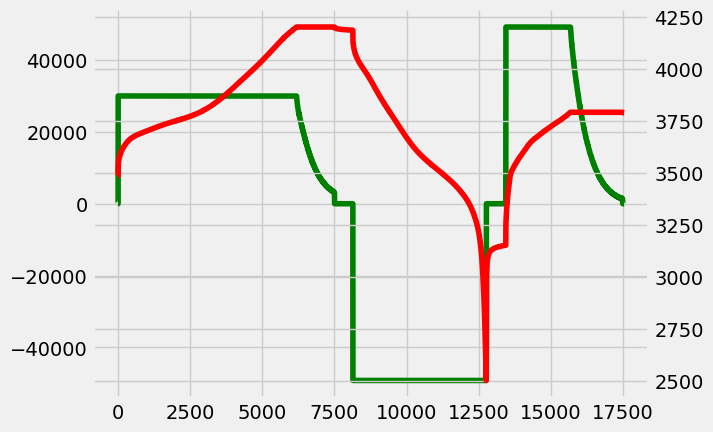

In [5]:
fig, ax1 = plt.subplots()

ax1.plot(df_list[0]['data']['curr'], 'g')
ax2 = ax1.twinx()
ax2.plot(df_list[0]['data']['vol'], 'r')

First of all, I'll create features for time-series.  
Using 'ds', Hour, Min, Second can be extracted and I'll add 'Series' as a additive feature.

In [19]:
FEATURES = ['curr', 'q_val', 'hour', 'min', 'series']
TARGET = 'vol'

In [28]:
from random import randint

draw_list = [randint(0, len(df_list)) for i in range(8)]
print(f'Following data will be used for train and validation, {draw_list}')

df_train = pd.concat([df_list[i]['data'] for i in draw_list[:-1]])
df_test  = pd.concat([df_list[i]['data'] for i in draw_list[-1:]])


Following data will be used for train and validation, [183, 130, 45, 3, 158, 153, 46, 172]


In [29]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [30]:

reg = xgb.XGBRegressor(booster='gbtree', n_estimators=1000, tree_method='gpu_hist', gpu_id=0)
reg.fit(X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100)

[0]	validation_0-rmse:2641.90011	validation_1-rmse:2644.72921
[100]	validation_0-rmse:13.47339	validation_1-rmse:16.19922
[200]	validation_0-rmse:13.40833	validation_1-rmse:16.13179
[300]	validation_0-rmse:13.39885	validation_1-rmse:16.12428
[400]	validation_0-rmse:13.39542	validation_1-rmse:16.12441
[500]	validation_0-rmse:13.39398	validation_1-rmse:16.12561
[600]	validation_0-rmse:13.39330	validation_1-rmse:16.12650
[700]	validation_0-rmse:13.39292	validation_1-rmse:16.12698
[800]	validation_0-rmse:13.39273	validation_1-rmse:16.12773
[900]	validation_0-rmse:13.39259	validation_1-rmse:16.12873
[999]	validation_0-rmse:13.39253	validation_1-rmse:16.12921


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

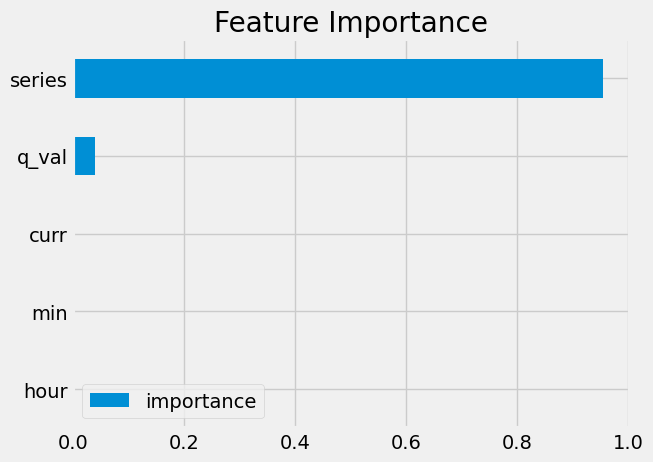

In [31]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [33]:
test = []
score = []
for df in df_list:
    pred = reg.predict(df['data'][FEATURES])
    test.append(pred)
    sc = np.sqrt(mean_squared_error(df['data'][TARGET], pred ))
    score.append(sc)


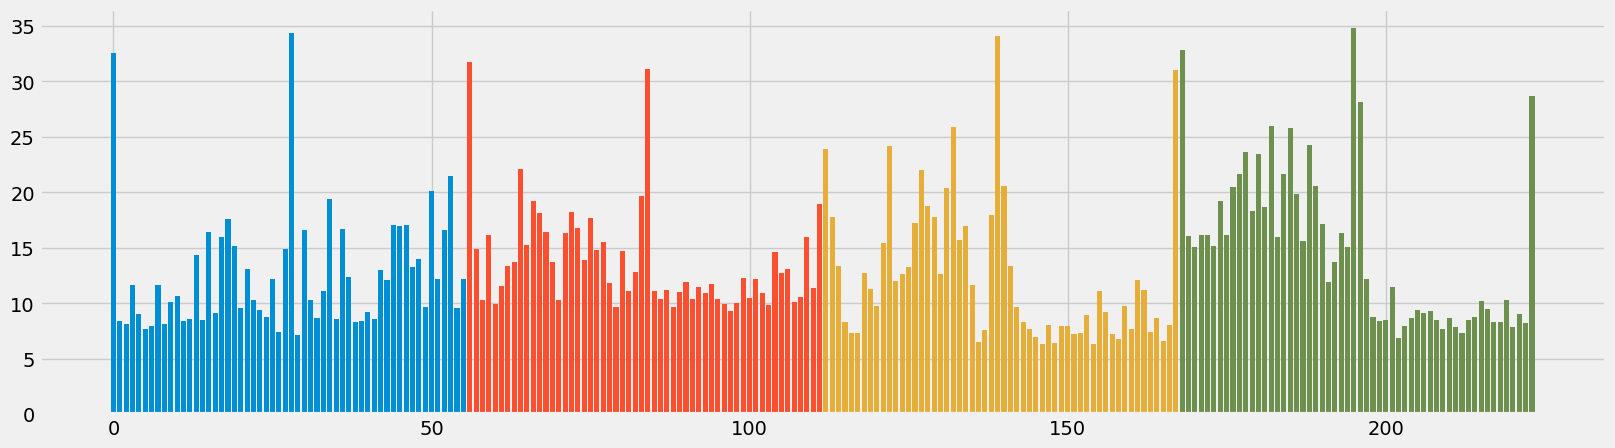

In [34]:
plt.figure(figsize=(18,5))
for i in range(4):
    plt.bar(np.arange(i*56, (i+1)*56), score[i*56:(i+1)*56])
